# imports and Load DataSet

In [1]:
# Basics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing & ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [2]:
df=pd.read_csv('cleaned_data.csv')
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,4.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [3]:
X = df.drop(columns=['loan_status'])
y = df['loan_status']  

# Data Preprocessing: Handling Categorical and Numerical Features with Pipelines

In [4]:
from sklearn.preprocessing import PowerTransformer, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

In [5]:
categorical_features_onehot = ['person_home_ownership', 'loan_intent', 'cb_person_default_on_file']
categorical_features_ordinal = ['loan_grade']
numerical_features = ['person_age', 'person_income', 'person_emp_length',
                      'loan_amnt', 'loan_int_rate', 'loan_percent_income',
                      'cb_person_cred_hist_length']

#Create preprocessing steps for each feature type
categorical_transformer_onehot = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore", drop="first", sparse=False))
    ])

categorical_transformer_ordinal = Pipeline(
    steps=[
        ("encoder", OrdinalEncoder())
    ])

numerical_transformer = Pipeline(
    steps=[
        ("encoder", PowerTransformer())
    ])

# Create a ColumnTransformer to apply preprocessing steps to each feature type
preprocessor = ColumnTransformer(transformers=[
    ('cat_onehot', categorical_transformer_onehot, categorical_features_onehot),
    ('cat_ordinal', categorical_transformer_ordinal, categorical_features_ordinal),
    ('num', numerical_transformer, numerical_features)
])

# Create pipeline 
pipeline = Pipeline(
    steps=[("preprocessor", preprocessor)]
)
# Fit pipeline
pipe_fit = pipeline.fit(X)

# Get the characteristic name of OneHotEncoder
onehot_feature_names = pipe_fit.named_steps['preprocessor'].named_transformers_['cat_onehot'].named_steps['encoder'].get_feature_names_out(categorical_features_onehot)

# Get the characteristic name of PowerTransformer
numerical_feature_names = pipe_fit.named_steps['preprocessor'].named_transformers_['num'].named_steps['encoder'].get_feature_names_out(numerical_features)

# Aggregate all feature names, including direct classification features
all_feature_names = np.concatenate([onehot_feature_names, numerical_feature_names, categorical_features_ordinal])

# Converts the data to a DataFrame with the specified characteristic name
data = pd.DataFrame(pipe_fit.transform(X), columns=all_feature_names)

In [6]:
data.head()

,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,cb_person_default_on_file_Y,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_grade
0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,3.0,-1.336154,0.122605,0.055283,2.536959,1.542368,2.368859,-0.707678
1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.802640,-3.260596,0.310084,-2.397295,0.098037,-0.619439,-1.446112
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,-0.289908,-3.260596,-1.048174,-0.538085,0.635719,2.321207,-0.707678
3,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,-0.935869,0.306533,0.055283,2.536959,1.322639,2.216550,-1.446112
4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,2.0,-0.590190,-0.021034,0.924802,2.536959,1.049033,2.270516,-0.203560


In [7]:
y.value_counts()

loan_status
0    25322
1     7089
Name: count, dtype: int64

In [38]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2, random_state=42, stratify=y)

In [39]:
X_train.shape

(25928, 17)

In [40]:
y_test.shape

(6483,)

# Training Machine Learning Model

## Train Logistic Regression

In [41]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

model = LogisticRegression()
model.fit(X_train, y_train)

feature_columns = X_train.columns.tolist()

# Print coefficients

for feature, coef in zip(feature_columns, model.coef_[0]):
    print(f"{feature}: {coef:.4f}")

# Predict and evaluate
y_pred = model.predict(X_test)
# Accuracy
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

person_home_ownership_OTHER: 0.4933
person_home_ownership_OWN: -1.5559
person_home_ownership_RENT: 0.6751
loan_intent_EDUCATION: -0.7870
loan_intent_HOMEIMPROVEMENT: 0.1173
loan_intent_MEDICAL: -0.1990
loan_intent_PERSONAL: -0.6198
loan_intent_VENTURE: -0.9886
cb_person_default_on_file_Y: -0.1215
person_age: 0.9663
person_income: 0.0055
person_emp_length: -0.7246
loan_amnt: -0.0302
loan_int_rate: 0.0585
loan_percent_income: -0.1117
cb_person_cred_hist_length: 0.7288
loan_grade: -0.0354
Accuracy: 0.8501
Confusion Matrix:
[[4801  264]
 [ 708  710]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.95      0.91      5065
           1       0.73      0.50      0.59      1418

    accuracy                           0.85      6483
   macro avg       0.80      0.72      0.75      6483
weighted avg       0.84      0.85      0.84      6483



In [42]:
pd.DataFrame({'y':y_test,'y_pred':y_pred}).head()

,y,y_pred
21156,0,0
26850,1,0
26333,0,0
24056,0,0
16694,1,1


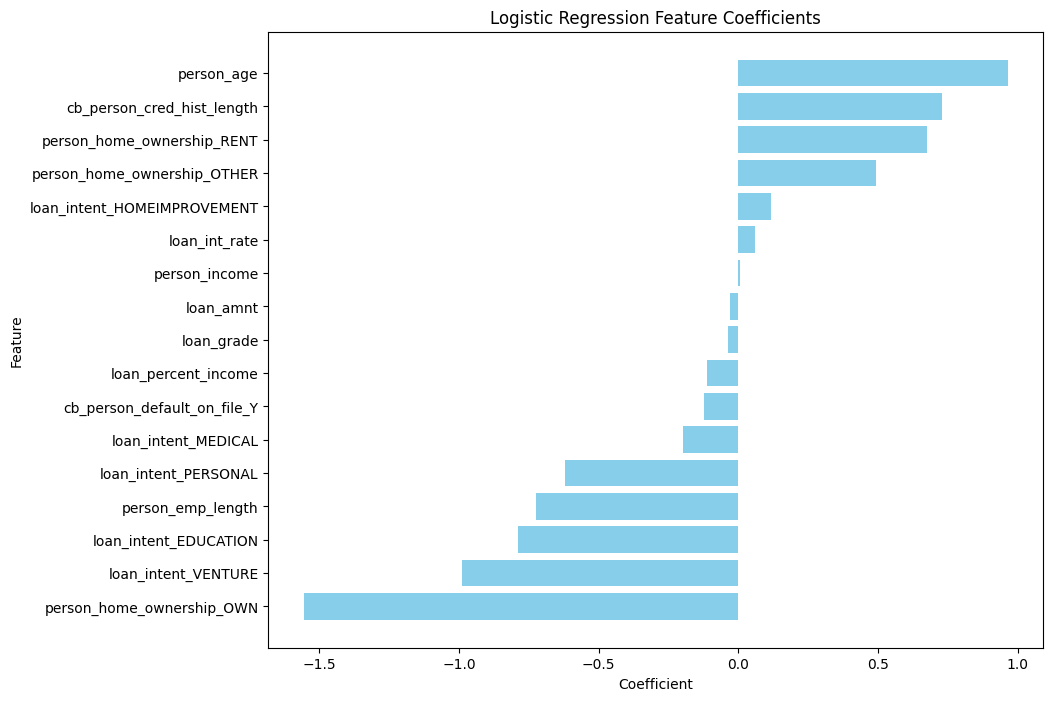

In [43]:
# Lấy coefficients
feature_names = X_train.columns
coefs = model.coef_[0] 

feat_imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': coefs
})
feat_imp_df = feat_imp_df.sort_values(by='importance', ascending=True)

plt.figure(figsize=(10,8))
plt.barh(feat_imp_df['feature'], feat_imp_df['importance'], color='skyblue')
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.title('Logistic Regression Feature Coefficients')
plt.show()

## Random Forest

In [44]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Train Random Forest
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train, y_train)

# Feature importance
feature_columns = X_train.columns.tolist()
for feature, importance in zip(feature_columns, rf.feature_importances_):
    print(f"{feature}: {importance:.4f}")

# Predict
y_pred = rf.predict(X_test)

# Evaluate
print(f"\nAccuracy: {accuracy_score(y_test, y_pred):.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

person_home_ownership_OTHER: 0.0011
person_home_ownership_OWN: 0.0179
person_home_ownership_RENT: 0.0819
loan_intent_EDUCATION: 0.0164
loan_intent_HOMEIMPROVEMENT: 0.0183
loan_intent_MEDICAL: 0.0168
loan_intent_PERSONAL: 0.0137
loan_intent_VENTURE: 0.0132
cb_person_default_on_file_Y: 0.0108
person_age: 0.1162
person_income: 0.0464
person_emp_length: 0.1470
loan_amnt: 0.0589
loan_int_rate: 0.0735
loan_percent_income: 0.1086
cb_person_cred_hist_length: 0.2246
loan_grade: 0.0347

Accuracy: 0.9331
Confusion Matrix:
[[5026   39]
 [ 395 1023]]

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      5065
           1       0.96      0.72      0.82      1418

    accuracy                           0.93      6483
   macro avg       0.95      0.86      0.89      6483
weighted avg       0.94      0.93      0.93      6483



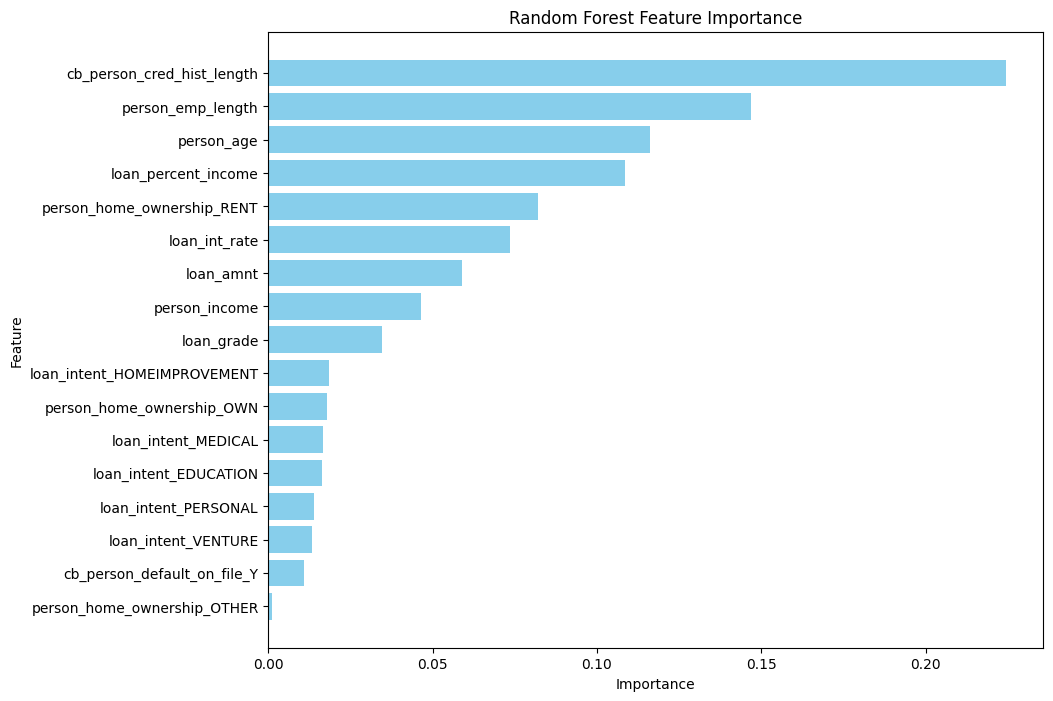

In [45]:
#  feature importance
importances = rf.feature_importances_
feature_names = X_train.columns

feat_imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
})

feat_imp_df = feat_imp_df.sort_values(by='importance', ascending=True)

plt.figure(figsize=(10,8))
plt.barh(feat_imp_df['feature'], feat_imp_df['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Random Forest Feature Importance')
plt.show()


## Train XGBoost

In [46]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# model
xgb_model = XGBClassifier(random_state=0, eval_metric='logloss')

# Train
xgb_model.fit(X_train, y_train)

# predict 
y_pred = xgb_model.predict(X_test)

# Evaluate
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9360
Confusion Matrix:
[[5019   46]
 [ 369 1049]]

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      5065
           1       0.96      0.74      0.83      1418

    accuracy                           0.94      6483
   macro avg       0.94      0.87      0.90      6483
weighted avg       0.94      0.94      0.93      6483



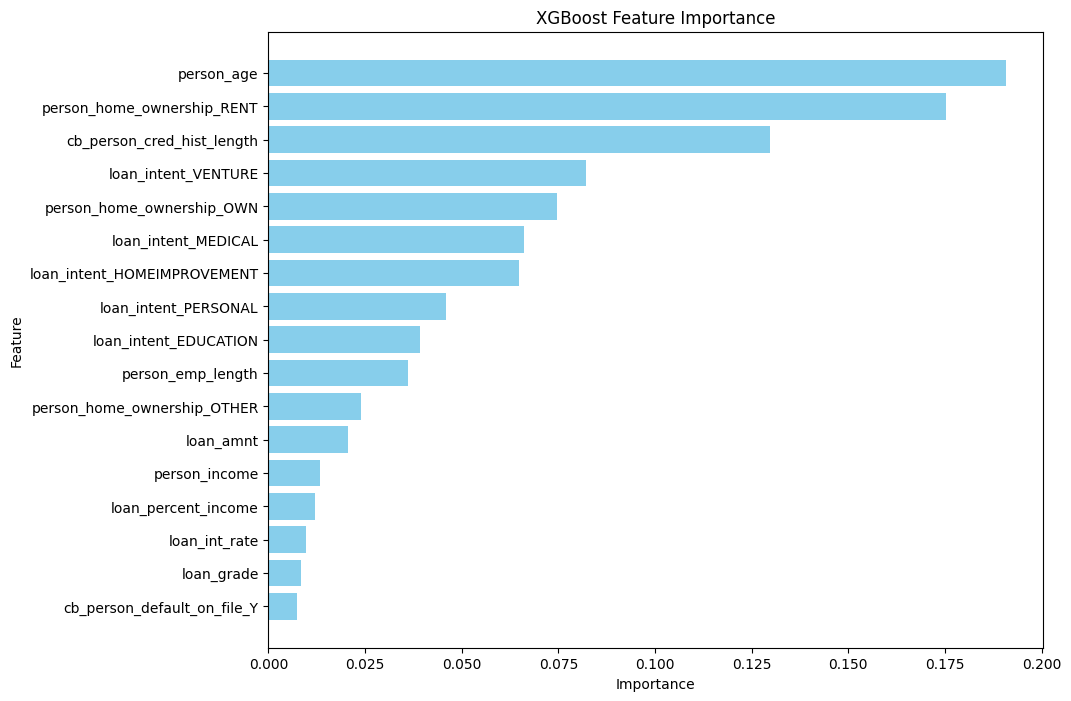

In [47]:
# feature importance
importances = xgb_model.feature_importances_
feature_names = X_train.columns

feat_imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
})

feat_imp_df = feat_imp_df.sort_values(by='importance', ascending=True)

plt.figure(figsize=(10,8))
plt.barh(feat_imp_df['feature'], feat_imp_df['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('XGBoost Feature Importance')
plt.show()


## Train catboost

In [48]:
K = df.drop('loan_status', axis=1)

In [49]:
cat_features = K.select_dtypes(include='object').columns.tolist()
K[cat_features] = K[cat_features].astype('category')
cat_features = K.select_dtypes(include='category').columns.tolist()
cat_features

['person_home_ownership',
 'loan_intent',
 'loan_grade',
 'cb_person_default_on_file']

In [50]:
from sklearn.model_selection import train_test_split

K_train, K_test, y_train, y_test = train_test_split(K, y, test_size=0.2, random_state=42, stratify=y)

In [51]:
import catboost
from catboost import CatBoostClassifier, Pool

train_pool = Pool(data=K_train, label=y_train, cat_features=cat_features)
test_pool = Pool(data=K_test, label=y_test, cat_features=cat_features)

model_cat = CatBoostClassifier(
    class_weights=[1, 3],
    loss_function='Logloss',
    iterations=500,
    learning_rate=0.1,
    depth=8,
    eval_metric='Accuracy',
    l2_leaf_reg=1,
    random_seed=42
)

model_cat.fit(train_pool, eval_set=test_pool, use_best_model=True)

0:	learn: 0.8450765	test: 0.8435454	best: 0.8435454 (0)	total: 30ms	remaining: 15s
1:	learn: 0.8446203	test: 0.8467647	best: 0.8467647 (1)	total: 47.5ms	remaining: 11.8s
2:	learn: 0.8453180	test: 0.8478378	best: 0.8478378 (2)	total: 62.6ms	remaining: 10.4s
3:	learn: 0.8457741	test: 0.8476231	best: 0.8478378 (2)	total: 81ms	remaining: 10s
4:	learn: 0.8458546	test: 0.8469793	best: 0.8478378 (2)	total: 98.2ms	remaining: 9.72s
5:	learn: 0.8513281	test: 0.8525593	best: 0.8525593 (5)	total: 112ms	remaining: 9.23s
6:	learn: 0.8522136	test: 0.8544908	best: 0.8544908 (6)	total: 126ms	remaining: 8.89s
7:	learn: 0.8543869	test: 0.8556712	best: 0.8556712 (7)	total: 138ms	remaining: 8.5s
8:	learn: 0.8570700	test: 0.8562077	best: 0.8562077 (8)	total: 151ms	remaining: 8.24s
9:	learn: 0.8580360	test: 0.8558858	best: 0.8562077 (8)	total: 166ms	remaining: 8.12s
10:	learn: 0.8601556	test: 0.8586758	best: 0.8586758 (10)	total: 181ms	remaining: 8.05s
11:	learn: 0.8594043	test: 0.8583539	best: 0.8586758 (10

In [52]:
# predict 
y_pred = model_cat.predict(K_test)

# Evaluate
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9311
Confusion Matrix:
[[4934  131]
 [ 316 1102]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.96      5065
           1       0.89      0.78      0.83      1418

    accuracy                           0.93      6483
   macro avg       0.92      0.88      0.89      6483
weighted avg       0.93      0.93      0.93      6483



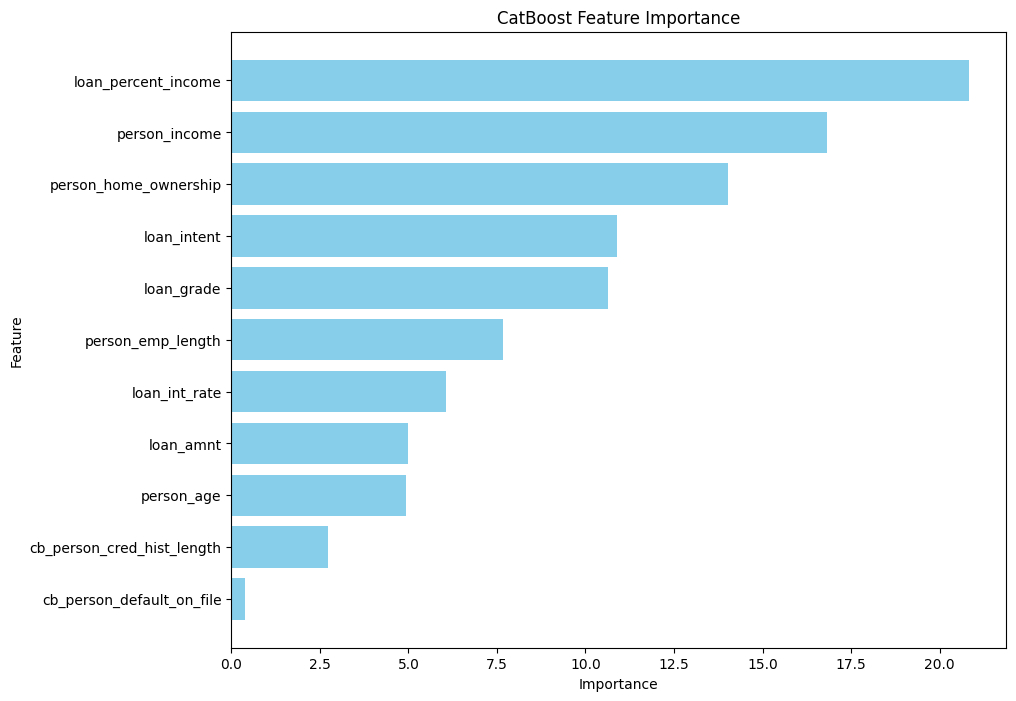

In [54]:
#feature importance
importances = model_cat.get_feature_importance(train_pool)
feature_names = K_train.columns
feat_imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
})

feat_imp_df = feat_imp_df.sort_values(by='importance', ascending=True)

plt.figure(figsize=(10,8))
plt.barh(feat_imp_df['feature'], feat_imp_df['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('CatBoost Feature Importance')
plt.show()

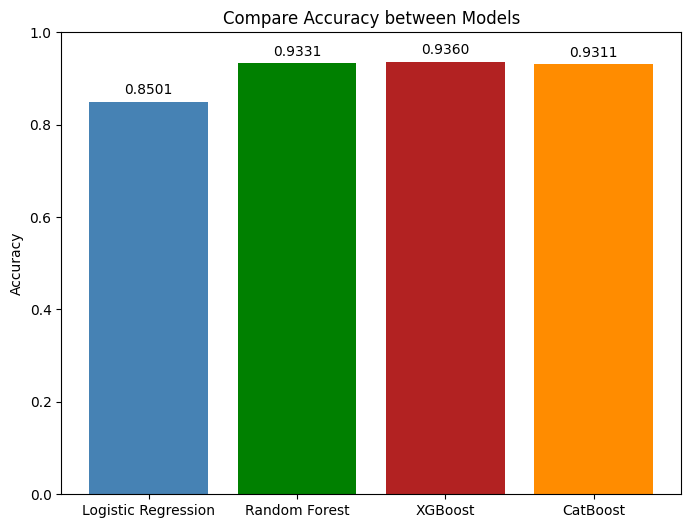

In [57]:
import matplotlib.pyplot as plt

models = ['Logistic Regression', 'Random Forest', 'XGBoost', 'CatBoost']
accuracies = [0.8501, 0.9331, 0.9360, 0.9311]

plt.figure(figsize=(8,6))
bars = plt.bar(models, accuracies, color = ['steelblue', 'green', 'firebrick', 'darkorange'])
plt.ylim(0,1)  # scale 0-1
plt.ylabel('Accuracy')
plt.title('Compare Accuracy between Models')

for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{acc:.4f}', ha='center', va='bottom')

plt.show()
